In [91]:
import csv
import pandas as pd
import numpy as np
import scipy.stats as stats
import math
import statistics
import matplotlib.pyplot as plt
import networkx as nx
import collections
import operator
import powerlaw
import plfit

ModuleNotFoundError: No module named 'plfit'

# 2 Differentially expressed genes

In [39]:
C = pd.read_csv(r"C:\Users\Mohanraj\Documents\TCGA-LUSC\TCGA-LUSC_rna_expr_data_C.txt", sep = " ")
N = pd.read_csv(r"C:\Users\Mohanraj\Documents\TCGA-LUSC\TCGA-LUSC_rna_expr_data_N.txt", sep = " ")

Leave only patients with both cancer and normal data, using the patient ID in the barcode (all the patients in the N database have data in the C database too)

In [40]:
for col in C:
    if not (any([(col[8:12]==c[8:12]) for c in N.columns])):
        del C[col]
C

,TCGA-77-7142-01A-11R-2045-07,TCGA-56-7823-01B-11R-2247-07,TCGA-22-5482-01A-01R-1635-07,TCGA-56-7582-01A-11R-2045-07,TCGA-56-7730-01A-11R-2125-07,TCGA-22-5471-01A-01R-1635-07,TCGA-43-6771-01A-11R-1820-07,TCGA-22-5491-01A-01R-1635-07,TCGA-85-7710-01A-11R-2125-07,TCGA-58-8386-01A-11R-2296-07,...,TCGA-92-7340-01A-21R-2045-07,TCGA-56-7731-01A-11R-2125-07,TCGA-39-5040-01A-21R-2125-07,TCGA-56-8309-01A-11R-2296-07,TCGA-22-5472-01A-01R-1635-07,TCGA-43-6773-01A-41R-1949-07,TCGA-43-7658-01A-11R-2125-07,TCGA-22-5489-01A-01R-1635-07,TCGA-56-8083-01A-11R-2247-07,TCGA-56-8082-01A-11R-2247-07
ENSG00000000003,18.020536,12.526580,7.520130,8.570585,34.546353,18.684145,4.483961,26.265688,6.525841,5.803590,...,10.962717,13.998369,3.734452,7.995145,23.158028,4.894193,16.225508,5.218992,14.892070,32.297229
ENSG00000000005,0.051976,0.017749,0.000000,0.000000,0.014922,0.039129,0.006072,0.007913,0.000000,0.000000,...,0.000000,0.020351,0.000000,0.023971,0.000000,0.015250,0.060181,0.016743,0.000000,0.025355
ENSG00000000419,26.567243,28.267701,31.099829,31.327989,35.131989,33.612966,16.904057,47.939591,46.018540,41.393558,...,37.196983,25.164337,49.400301,27.449844,30.444776,14.300066,63.921993,29.871424,31.706126,50.747991
ENSG00000000457,2.122730,1.864069,1.899460,2.419168,2.047178,2.173772,1.119243,2.339504,4.882686,1.643590,...,1.702293,1.225780,2.338103,2.242792,2.984920,1.394726,7.362284,3.062657,3.927721,2.499827
ENSG00000000460,2.412130,3.582111,1.689431,2.884558,3.351919,2.789891,1.169817,2.527843,3.104733,1.082517,...,1.785573,0.930736,2.586417,2.034096,1.458628,1.098614,7.919506,4.786459,4.751678,2.291811
ENSG00000000938,4.205743,1.595752,1.350192,3.100640,1.428090,3.998591,1.398628,1.243152,3.027341,10.406187,...,4.166060,8.431808,1.624999,19.435288,7.516092,6.947262,3.625786,4.865272,1.773935,2.467627
ENSG00000000971,4.896562,5.315143,4.443208,6.708845,1.834698,3.335541,9.253004,1.865966,34.526262,5.064992,...,17.362631,23.454584,1.982730,44.461143,24.983019,13.652155,1.808178,11.246094,8.593680,3.756390
ENSG00000001036,27.696014,23.654312,28.480229,16.366657,13.126499,23.266258,16.521400,26.514525,14.271703,12.796524,...,27.860683,29.198933,27.472402,19.282607,22.115192,22.486382,19.793734,16.451120,13.620139,26.279002
ENSG00000001084,10.028305,68.756039,74.313098,118.276670,69.327318,23.454050,0.329228,33.826146,4.154851,8.992422,...,10.111642,10.147422,4.302640,12.481228,13.410620,94.695444,4.015298,5.999440,4.474007,20.888335
ENSG00000001167,11.782569,17.590674,10.254374,19.844074,12.179612,7.302404,5.702644,4.178549,15.803207,7.004460,...,6.637829,6.796353,22.628566,9.438083,9.074606,9.515498,23.306856,19.112425,12.071453,9.683216


Delete the genes (rows) with at least one zero value

In [41]:
MC = C.to_records()
MN = N.to_records()
Cclean = C.to_records()
Nclean = N.to_records()

In [42]:
to_delete = set()  # Set of index to delete
for i in range(len(MC)):
    if (0 in MC[i]):
        to_delete.add(i)

for i in range(len(MN)):
    if (0 in MN[i]):
        to_delete.add(i)
        
Cclean = np.delete(Cclean, list(to_delete), axis=0)
Nclean = np.delete(Nclean, list(to_delete), axis=0)

Keep only the genes with a One-way ANOVA familywise q-value < 0.05 (calculated with Bonferroni threshold), and a fold change greater than 1.5 or below -1.5.

In [43]:
# Bonferroni threshold
def bonferroni_thresh(alpha_fwe, n):
    return alpha_fwe / n
bon_thresh = bonferroni_thresh(0.05, len(Cclean[0])) # P-value to use calculated with Bonferroni threshold that gives a familywise error < 0.05

In [44]:
genes = []  # List of the names of the differential expressed genes
idx = [] # Index to drop
# Lists for volcano plot
green = []
red = []
grey = []
yg = []
yr = []
ygrey = []

for i in range(len(Cclean)):
    p = stats.f_oneway([math.log(y,2) for y in list(Cclean[i])[1:]], [math.log(x,2) for x in list(Nclean[i])[1:]])[1]
    fc = math.log(statistics.mean(list(Cclean[i])[1:])/statistics.mean(list(Nclean[i])[1:]),2)
    if (p < bon_thresh) and (fc > 2):
        genes.append(Cclean[i][0])
        red.append(fc)
        yr.append(-math.log(p,10))
    elif (p < bon_thresh) and (fc < -2):
        genes.append(Cclean[i][0])
        green.append(fc)
        yg.append(-math.log(p,10))
    else:
        grey.append(fc)
        ygrey.append(-math.log(p,10))
        idx.append(i)

In [45]:
# Drop non differential expressed genes
Cclean = np.delete(Cclean, idx, axis=0)
Ncelan = np.delete(Nclean, idx, axis=0)

# Drop header with genes names
Cex = np.array([0 for i in range(len(Cclean[1])-1)])
Nex = np.array([0 for i in range(len(Cclean[1])-1)])
for i in range(len(Cclean)):
    Cex = np.vstack((Cex, list(Cclean[i])[1:]))
    Nex = np.vstack((Nex, list(Nclean[i])[1:]))
Cex = np.delete(Cex,0,0)
Nex = np.delete(Nex,0,0)

In [46]:
print("{} of the alayized genes are differentially expressed, they are {}% of all analyzed genes".format(len(genes),round( len(genes)/len(MC)*100 ,2)))

1695 of the alayized genes are differentially expressed, they are 2.99% of all analyzed genes


Volcano plot, in green the downed regulated genes, in red the up regulated genes

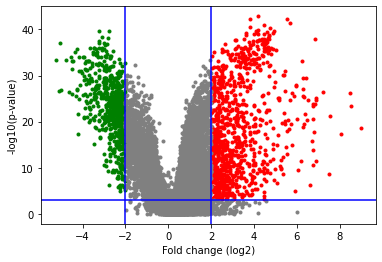

In [10]:
plt.plot(red, yr, '.', color='red')
plt.plot(green,yg,".", color="green")
plt.plot(grey,ygrey,".",color="grey")
plt.xlabel("Fold change (log2)")
plt.ylabel("-log10(p-value)")
plt.axvline(2, color='b')
plt.axvline(-2, color='b')
plt.axhline(-math.log(bon_thresh,10), color='b')
# Save plot
#plt.savefig("VolcanoPlot")

# 3 Co-expression network

In [47]:
# Apply log2 before the threshold
for i in range(len(Cclean)):
    Cex[i] = [math.log(j,2) for j in (Cex[i])]
    Nex[i] = [math.log(j,2) for j in (Nex[i])]

corr_C = np.corrcoef(Cex)
corr_N = np.corrcoef(Nex)

Set significant threshold

In [12]:
t = 0.6
for i in range(len(corr_C)):
    for j in range(len(corr_C[i])):
        if i==j:          # Set correlation with itself to 0
            corr_C[i][j] = 0
            corr_N[i][j] = 0
        else:
            if corr_C[i][j] > t:
                corr_C[i][j] = 1
            elif corr_C[i][j] < -t:
                corr_C[i][j] = -1
            else:
                corr_C[i][j] = 0
                
            if corr_N[i][j] > t:
                corr_N[i][j] = 1
            elif corr_N[i][j] < -t:
                corr_N[i][j] = -1
            else:
                corr_N[i][j] = 0

Degree distribution of C

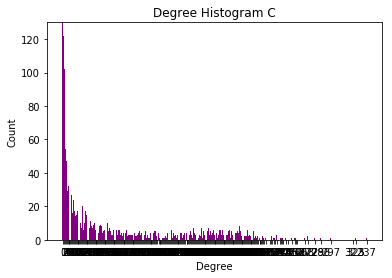

In [15]:
C = nx.from_numpy_array(corr_C)

degree_sequence = [d for n, d in C.degree()]
degreeCount = collections.Counter(sorted(degree_sequence))
deg, cnt = zip(*degreeCount.items())
fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color="purple")
plt.title("Degree Histogram C")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)
plt.ylim(top=130)
plt.show()

Find the hubs (5% of the nodes with the highest degree) in C

In [16]:
degreeC = dict(C.degree())  # Make degree a dictionary
indexesC = sorted(degreeC, key=degreeC.get, reverse=True) # Sort index by value to find the hubs
indexesC = indexesC[:round(len(indexesC)*0.05)]
# Find the name of hubs genes
hubsC = operator.itemgetter(*indexesC)(genes)

Do the same with N

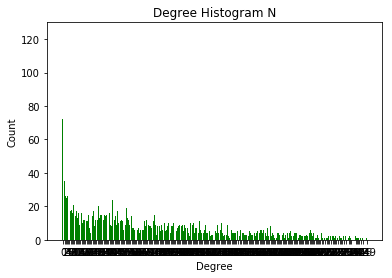

In [17]:
N = nx.from_numpy_array(corr_N)

degree_sequence = [d for n, d in N.degree()]
degreeCount = collections.Counter(sorted(degree_sequence))
deg, cnt = zip(*degreeCount.items())
fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color="green")
plt.title("Degree Histogram N")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)
plt.ylim(top=130)
plt.show()

In [19]:
degreeN = dict(N.degree())  # Make degree a dictionary
indexesN = sorted(degreeN, key=degreeN.get, reverse=True) # Sort index by value to find the hubs
indexesN = indexesN[:round(len(indexesN)*0.05)]
# Find the name of hubs genes
hubsN = operator.itemgetter(*indexesN)(genes)

Find the hubs in C that are not present in N

In [20]:
hubs = [item for item in hubsC if item not in hubsN]

### Differential Co Expressed network

In [16]:
import numpy as np
from scipy import stats

In [73]:
corr_C = np.corrcoef(Cex)
corr_N = np.corrcoef(Nex)

In [56]:
#result = np.array([stats.pearsonr(x,y) for x,y in zip(corr_C,corr_N)])

In [61]:
def zTransform(r):
    z = 1/2*np.log((1 + r) / (1 - r))
    return z

In [93]:
DCE = corr_C.copy()

In [94]:
for i in range(len(corr_C)):
    for j in range(len(corr_C[i])):
        p1 = corr_C[i][j]
        p2 = corr_N[i][j]
        z1 = zTransform(p1)
        z2 = zTransform(p2)
        Z = (z1-z2)/(np.sqrt((1/(len(corr_C)-3))+(1/(len(corr_N)-3))))
        if i==j:          
            DCE[i][j] = 0
        else:
            if Z < 3 and Z > -3:
                DCE[i][j] = 0
            elif Z < -3:
                DCE[i][j]= -1
            else:
                DCE[i][j] = 1

C:\Users\Mohanraj\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
C:\Users\Mohanraj\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


In [95]:
DCE

array([[ 0., -1., -1., ...,  1.,  1.,  1.],
       [-1.,  0., -1., ..., -1., -1., -1.],
       [-1., -1.,  0., ..., -1.,  0.,  0.],
       ...,
       [ 1., -1., -1., ...,  0.,  0.,  1.],
       [ 1., -1.,  0., ...,  0.,  0.,  0.],
       [ 1., -1.,  0., ...,  1.,  0.,  0.]])

In [96]:
D = nx.from_numpy_array(DCE)

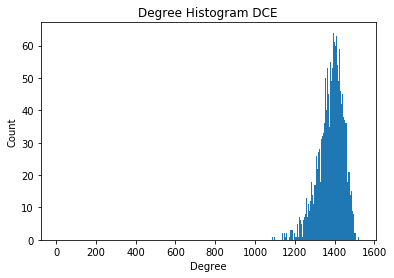

In [97]:
degree_sequence = [d for n, d in D.degree()]
bins = range(0,max(degree_sequence),5)
plt.hist(degree_sequence, bins = bins)
plt.title("Degree Histogram DCE")
plt.ylabel("Count")
plt.xlabel("Degree")
# save plot
#plt.savefig("Degree Distribution N")

plt.show()

In [98]:
degreeD = dict(D.degree())  # Make degree a dictionary
indexesD = sorted(degreeD, key=degreeD.get, reverse=True) # Sort index by value to find the hubs
indexesD = indexesD[:round(len(indexesD)*0.05)]
# Print the list of
hubsD = operator.itemgetter(*indexesD)(genes)
for i in range(len(hubsD)):
    print(hubsD[i], "with degree:",sorted(degreeD.values(), reverse = True)[i])

ENSG00000113555 with degree: 1533
ENSG00000198901 with degree: 1523
ENSG00000007129 with degree: 1506
ENSG00000175899 with degree: 1506
ENSG00000161940 with degree: 1503
ENSG00000131018 with degree: 1501
ENSG00000170989 with degree: 1499
ENSG00000183019 with degree: 1499
ENSG00000171115 with degree: 1497
ENSG00000166927 with degree: 1496
ENSG00000169418 with degree: 1496
ENSG00000170909 with degree: 1496
ENSG00000074660 with degree: 1495
ENSG00000261371 with degree: 1495
ENSG00000139567 with degree: 1494
ENSG00000035499 with degree: 1492
ENSG00000051180 with degree: 1492
ENSG00000068831 with degree: 1492
ENSG00000130307 with degree: 1492
ENSG00000149564 with degree: 1492
ENSG00000167261 with degree: 1492
ENSG00000066056 with degree: 1490
ENSG00000101057 with degree: 1490
ENSG00000069122 with degree: 1489
ENSG00000038945 with degree: 1488
ENSG00000114346 with degree: 1488
ENSG00000123342 with degree: 1488
ENSG00000143110 with degree: 1488
ENSG00000146670 with degree: 1488
ENSG0000016474

Calculating best minimal value for power law fit


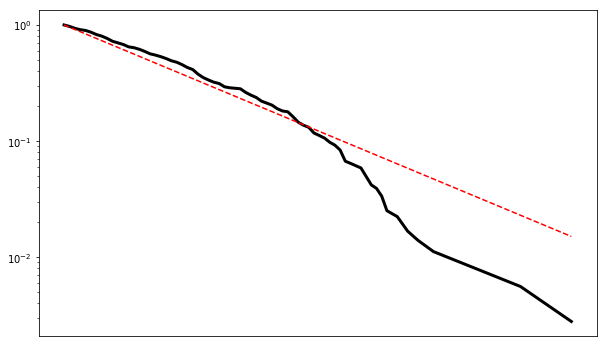

In [99]:
degree_sequence = sorted([d for n, d in D.degree()], reverse=True)
fit = powerlaw.Fit(degree_sequence) 
plt.figure(figsize=(10, 6))
fig = fit.plot_ccdf(linewidth=3, color='black')
fit.power_law.plot_ccdf(ax=fig, color='r', linestyle='--') 